In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import mysql.connector

In [6]:
# to connect with the database
db = mysql.connector.connect(host = 'localhost',
                            username = 'root',
                            password = 'V0717y@',
                            database = 'ecommerce')

cur = db.cursor() #to activate the cursor in the database


## QUERIES

# 1. List all unique cities where customers are located.



In [7]:
query = """ select distinct customer_city from customers """

cur.execute(query) #excute the query 

data = cur.fetchall() #fetch the query 
df = pd.DataFrame(data, columns= ['City'])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [8]:
query = """ select count(order_id)
        from orders 
        where year(order_purchase_timestamp) = 2017 """

cur.execute(query) #excute the query 

data = cur.fetchall() #fetch the query 
'total number of oders placed in 2017 are : ',data [0][0]

('total number of oders placed in 2017 are : ', 45101)

# 3. Find the total sales per category.

In [9]:
query = """ select products.product_category category,
            round(sum(payments.payment_value),2) sales
            from products join order_items
                 on products.product_id = order_items.product_id
            join payments
                on payments.order_id = order_items.order_id
            group by category """  
#we have used 3 tables in the join where in the from products table we've taken product_id &
# joined it with the order_items table product id.... and in the secound join we've taken oder_id table as a common  in the the then
# we've join it here 

cur.execute(query) #excute the query 

data = cur.fetchall() #fetch the query 
df = pd.DataFrame(data, columns= ['products_category','sales'])
df.head(10)

,products_category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
5,computer accessories,1585330.45
6,housewares,1094758.13
7,babies,539845.66
8,toys,619037.69
9,Furniture office,646826.49


# 4. Calculate the percentage of orders that were paid in installments.

In [10]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 
            end ))/count(*)*100 
            from payments """ 

cur.execute(query) #excute the query 

data = cur.fetchall() #fetch the query 
'total  %age of orders paid in installments',data

('total  %age of orders paid in installments', [(Decimal('99.9981'),)])

# 5. Count the number of customers from each state. 

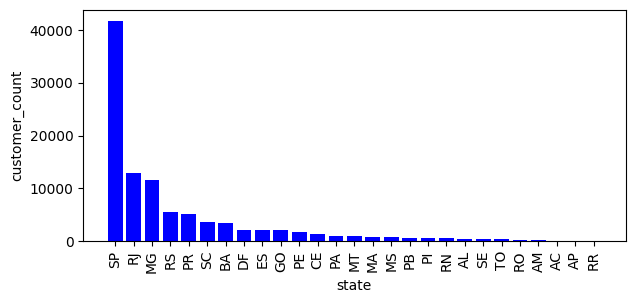

In [11]:
query = """ select customer_state, count(customer_id)
from customers
group by customer_state """ 

cur.execute(query) #excute the query 

data = cur.fetchall() #fetch the query 
df = pd.DataFrame(data, columns = ['state', 'count']) #creating dataframes

df = df.sort_values(by='count', ascending=False)
plt.figure(figsize = (7,3))
plt.bar(df['state'], df['count'], color = 'blue')
plt.xticks(rotation= 90)
plt.xlabel('state')
plt.ylabel('customer_count')
plt.show()

#  6. Calculate the number of orders per month in 2018.

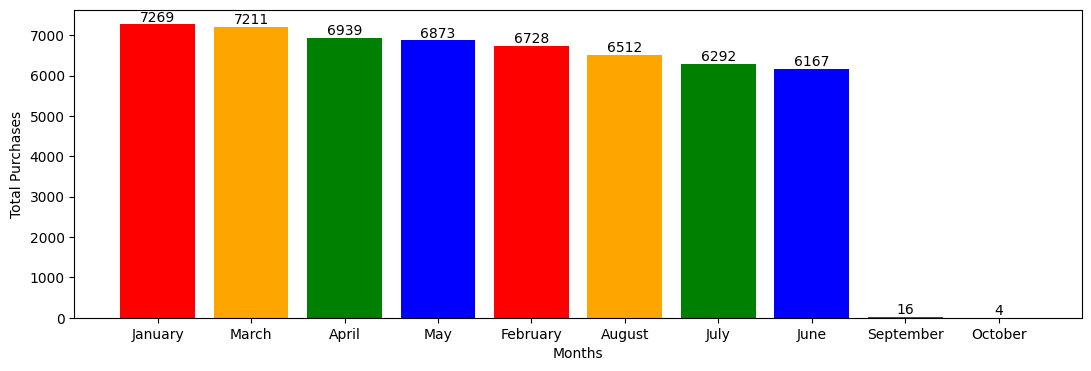

In [12]:
query = """ select monthname(order_purchase_timestamp) month, count(order_id) count
from orders where year(order_purchase_timestamp)= 2018
group by month""" 

cur.execute(query) #excute the query 

data = cur.fetchall() #fetch the query 

df= pd.DataFrame(data, columns= ['Months','Total Purchases'])
df = df.sort_values(by='Total Purchases', ascending = False)

plt.figure(figsize=(13,4))
ax= plt.bar(df['Months'],df['Total Purchases'], color = ['red','orange','green','blue'])
plt.bar_label(ax, labels = df['Total Purchases']) #adding labels with matplotlib
plt.xlabel('Months')
plt.ylabel('Total Purchases')
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [13]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc
""" 

cur.execute(query) #excute the query 

data = cur.fetchall()
df = pd.DataFrame(data, columns=['City', 'Average_Products_per_Order'])
df.head(10)


,City,Average_Products_per_Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [14]:
query = """ select products.product_category category,
round((sum(payments.payment_value)/(select  sum(payment_value) from payments))*100,3) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category 
order by sales desc
""" 

cur.execute(query) #excute the query 

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Products', '%age of total Revenue '])
df.head(10)

,Products,%age of total Revenue
0,bed table bath,10.698
1,HEALTH BEAUTY,10.353
2,computer accessories,9.903
3,Furniture Decoration,8.934
4,Watches present,8.928
5,sport leisure,8.696
6,housewares,6.838
7,automotive,5.324
8,Garden tools,5.236
9,Cool Stuff,4.870


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
query = """ select products.product_category,
count(order_items.product_id),round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
""" 

cur.execute(query) #excute the query 
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Products', 'Order_count','Price'])
df

# for calculating the Correlation 
arr1 = df['Order_count']
arr2 = df['Price']
c= np.corrcoef([arr1, arr2]) #numpy have defined func for checking the correlation -1 means INVERSLY related +1 means DIRECTLY related 
print('the correlation b/w the price and order_count is ', c [0][1], 'i.e Not Very Significant Change ' )

the correlation b/w the price and order_count is  -0.10631514167157567 i.e Not Very Significant Change 


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

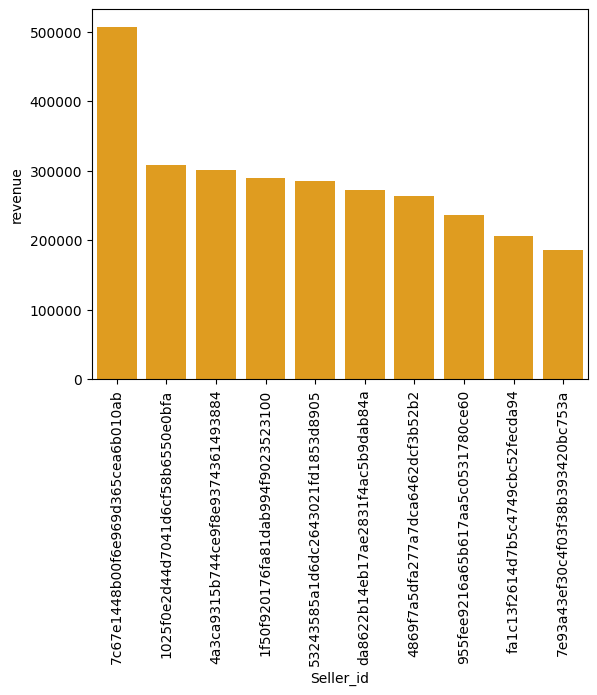

In [16]:
query = """ select * , dense_rank() over(order by revenue desc) as rn 
from
(select order_items.seller_id, round(sum(payments.payment_value),3) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) 
as a
""" 

cur.execute(query) #excute the query 
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Seller_id', 'revenue','Rank'])
df = df.head(10)
sns.barplot(x='Seller_id', y = 'revenue', data = df, color= 'orange' )
plt.xticks(rotation = 90)
plt.show()


# 11. Calculate the moving average of order values for each customer over their order history.

In [17]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) 
over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) 
as mov_avg

from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id ) 
as a
""" 

cur.execute(query) #excute the query 
data = cur.fetchall() 
df = pd.DataFrame(data, columns =['customer_id','order_purchase_timestamp', 'payment', 'mov_avg'])
df.head(20)

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# 12. Calculate the cumulative sales per month for each year.

<function matplotlib.pyplot.show(close=None, block=None)>

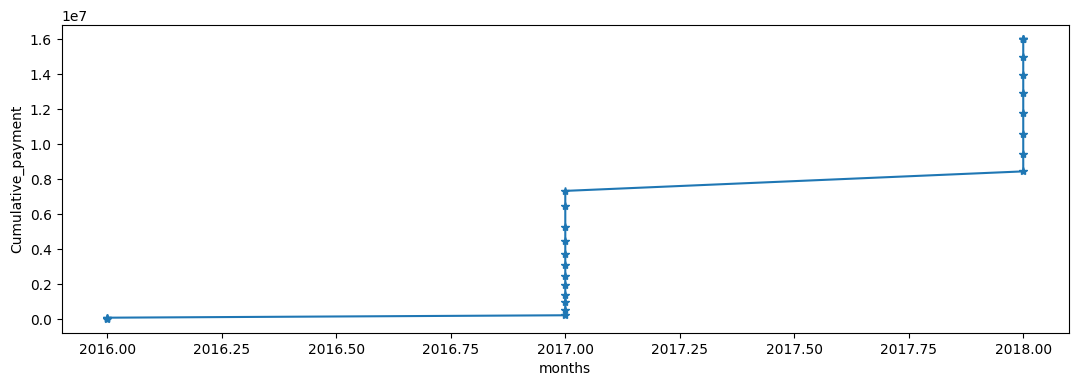

In [18]:
query = """ select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales

from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment 
from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) 
as a
""" 

cur.execute(query) #excute the query 
data = cur.fetchall() 
df = pd.DataFrame(data, columns=['year','months','payment', 'cumulative_payment'])
df

plt.figure(figsize=(13,4))
plt.plot(df['year'],df['cumulative_payment'],'*-')
plt.xlabel('months')
plt.ylabel('Cumulative_payment')

plt.show

# 13. Calculate the year-over-year growth rate of total sales.

In [19]:
query = """ with a as
(select year(orders.order_purchase_timestamp)as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,
((payment - lag(payment, 1) over(order by years)) / lag (payment, 1) over(order by years)) * 100 
from a
""" 

cur.execute(query) #excute the query 
data = cur.fetchall() 
df = pd.DataFrame(data, columns=['Year','Year Over Year %age Growth'])
df

,Year,Year Over Year %age Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14. Calculate the RETENTION rate of customers, defined as the %age of customers who make ANOTHER purchase within 6 months of their FIRST purchase. 

In [20]:
query = """ with a as 
(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id ),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order 
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order 
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count( distinct a.customer_id)/ count(distinct b. customer_id))
from a left join b
on a.customer_id = b.customer_id ;
""" 

cur.execute(query) #excute the query 
data = cur.fetchall() 
data

[(None,)]

# 15. Identify the top 3 customers who spent the most money in each year.

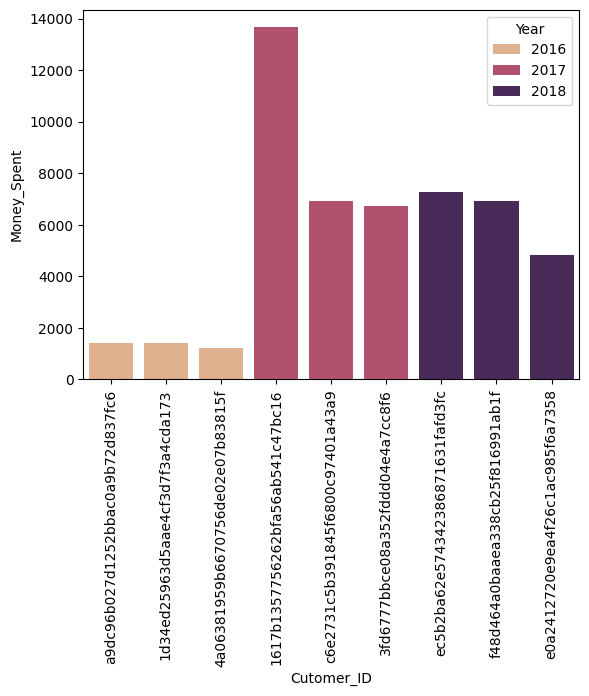

In [21]:
query = """ select years,customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp)years,
orders.customer_id,
sum(payments.payment_value)payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id)
as a

where d_rank <= 3
"""
cur.execute(query) #excute the query 
data = cur.fetchall() 
df = pd.DataFrame(data, columns=['Year','Cutomer_ID', 'Money_Spent', 'Ranks'])
sns.barplot(x= 'Cutomer_ID', y= 'Money_Spent', data = df, hue = 'Year', palette= ("flare"))
plt.xticks(rotation = 90)
plt.show()
